### 0. Importing and loading the data


In [51]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [1]:
# importing packages
%matplotlib inline
import json
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.dates as mdates
import pandas as pd
import datetime
import statistics
import time
import numpy as np
from calendar import monthrange
from matplotlib.dates import YearLocator, MonthLocator, DayLocator, HourLocator, DateFormatter, drange, date2num, num2date


In [2]:
month_locator = MonthLocator()


In [3]:
# importing commit data of bitcoin, numpy, react projects on github
with open('bitcoin_commits.json') as f:
    bitcoin_data = json.load(f)
with open('numpy_commits.json') as f:
    numpy_data = json.load(f)
with open('react_commits.json') as f:
    react_data = json.load(f)

In [4]:
# creating pandas dataframe from the loaded files
b_df = pd.DataFrame(bitcoin_data)
n_df = pd.DataFrame(numpy_data)
r_df = pd.DataFrame(react_data)

### 1. Preprocessing the data
1. change the time from seconds to datetime
2. sort the array by commit time
3. create a field "month"

In [5]:
# 1. Changing the time from seconds to the datetime 
# Run this only once (when first loading the data)
b_df["committer_time"] = [datetime.datetime.fromtimestamp(i/1000.0) for i in b_df["committer_time"]]
n_df["committer_time"] = [datetime.datetime.fromtimestamp(i/1000.0) for i in n_df["committer_time"]]
r_df["committer_time"] = [datetime.datetime.fromtimestamp(i/1000.0) for i in r_df["committer_time"]]

In [6]:
# 2. Sorting by time
n_df = n_df.sort_values(by=['committer_time'])
b_df = b_df.sort_values(by=['committer_time'])
r_df = r_df.sort_values(by=['committer_time'])

In [7]:
# 3. Creating the field "month"
# n_df["month"]=[100*i.year+i.month for i in n_df["committer_time"]]
# r_df["month"]=[100*i.year+i.month for i in r_df["committer_time"]]
# b_df["month"]=[100*i.year+i.month for i in b_df["committer_time"]]

n_df["month"] = [datetime.datetime(i.year, i.month, 1) for i in n_df["committer_time"]]
r_df["month"] = [datetime.datetime(i.year, i.month, 1) for i in r_df["committer_time"]]
b_df["month"] = [datetime.datetime(i.year, i.month, 1) for i in b_df["committer_time"]]

### 2. Preliminary information about the projects

In [8]:
index = ['bitcoin', 'numpy', 'react']
column = ['number of commits', 'number of contributors', 'first date', 'last date']

In [9]:
b_num_commit = b_df.shape[0]
n_num_commit = n_df.shape[0]
r_num_commit = r_df.shape[0]

In [10]:
b_num_cont = len(set(b_df["committer_name_dedup"]))
n_num_cont = len(set(n_df["committer_name_dedup"]))
r_num_cont = len(set(r_df["committer_name_dedup"]))

In [11]:
b_start = b_df['committer_time'][0]
n_start = n_df['committer_time'][0]
r_start = r_df['committer_time'][0]

In [12]:
b_last_list = list(b_df['committer_time'])
b_last_list.sort()
n_last_list = list(n_df['committer_time'])
n_last_list.sort()
r_last_list = list(r_df['committer_time'])
r_last_list.sort()

In [13]:
projects = pd.DataFrame([[b_num_commit,b_num_cont,b_start,b_last_list[-1]],\
                         [n_num_commit,n_num_cont,n_start,b_last_list[-1]],\
                         [r_num_commit,r_num_cont,r_start,b_last_list[-1]]],index=index,columns=column)
projects

,number of commits,number of contributors,first date,last date
bitcoin,36302,812,2009-08-29 23:46:39,2018-01-18 10:05:40
numpy,24552,751,2001-12-18 10:45:10,2018-01-18 10:05:40
react,24157,1358,2013-05-29 08:54:02,2018-01-18 10:05:40


### 3. Options for picking the dividing point
1. largest number of new contributors
2. largest increase in the number of contributors

In [14]:
def pick_div2(df):
    '''
    return the dividing point in time between old and new contributors
    i.e the month with the largest number of new contributors
    '''
    months = list(set(df['month']))
    months.sort()
    div_month = 0
    largest = 0
    old_users = set()
    for i in months:
        is_month_i = df[df["month"]==i]
        curr_month_users = set(is_month_i["committer_name_dedup"])
        new_users = curr_month_users - old_users
        old_users = old_users.union(new_users)
        if len(new_users) > largest:
            largest = len(new_users)
            div_month = i
        prev_month = len(curr_month_users)
    return div_month

In [15]:
def pick_div(df):
    '''
    return the dividing point in time between old and new contributors
    i.e the month with the largest increase in the number of contributors
    '''
    months = list(set(df['month']))
    months.sort()
    prev_month = 0
    div_month = 0
    largest_jump = 0
    for i in months:
        is_month_i = df[df["month"]==i]
        diff = len(set(is_month_i["committer_name_dedup"])) - prev_month
        if diff > largest_jump:
            largest_jump = diff
            div_month = i
        prev_month = len(set(is_month_i["committer_name_dedup"]))
    return div_month

In [16]:
print("Numpy's diving point using the first method of picking the dividing point is {}".format(pick_div(n_df)))
print("Numpy's diving point using the second method of picking the dividing point is {}".format(pick_div2(n_df)))
print("React's diving point using the first method of picking the dividing point is {}".format(pick_div(r_df)))
print("React's diving point using the second of picking the dividing point is {}".format(pick_div2(r_df)))
print("Bitcoin's diving point using the first method of picking the dividing point is {}".format(pick_div(b_df)))
print("Bitcoin's diving point using the second of picking the dividing point is {}".format(pick_div2(b_df)))

Numpy's diving point using the first method of picking the dividing point is 2015-10-01 00:00:00
Numpy's diving point using the second method of picking the dividing point is 2016-01-01 00:00:00
React's diving point using the first method of picking the dividing point is 2015-10-01 00:00:00
React's diving point using the second of picking the dividing point is 2015-10-01 00:00:00
Bitcoin's diving point using the first method of picking the dividing point is 2014-03-01 00:00:00
Bitcoin's diving point using the second of picking the dividing point is 2014-03-01 00:00:00


##### Findings
1. Looks like the two methods are returning almost identical month proving that they are good identifier of the dividing point

### 4. Visualizing the dividing point

In [52]:
def vis_div(df, title):
    '''
    visualize the dividing point
    '''
    div_month = pick_div(df)
    months = set(df['month'])
    months = list(months)
    months.sort()
    month_dict = {}
    div_size = 0
    for i in months:
        is_month_i = df[df["month"]==i]
        month_dict[i]=len(set(is_month_i["committer_name_dedup"]))
            
            
    plt.ylabel('Total Number of Contributors', fontsize=20)
    plt.xlabel('Year', fontsize=20)
    plt.title(title, fontsize=30)
    
    plt.gca().xaxis.set_major_locator(MonthLocator(range(1,13), interval=6))
    plt.gca().xaxis.set_major_formatter(DateFormatter('%b %Y'))
    plt.gca().xaxis.set_minor_locator(month_locator)
    
    all_months = list(month_dict.keys()).sort()
    plt.plot(list(month_dict.keys()),list(month_dict.values()))
    plt.axvline(x=div_month, color='orange')
    plt.rcParams['figure.figsize'] = [15, 10]

    plt.gcf().autofmt_xdate()
    plt.show()

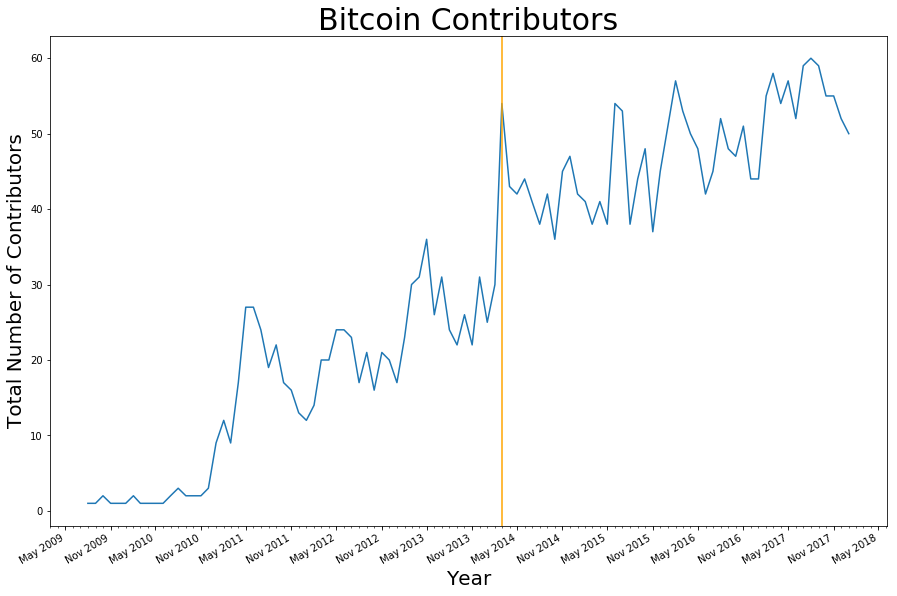

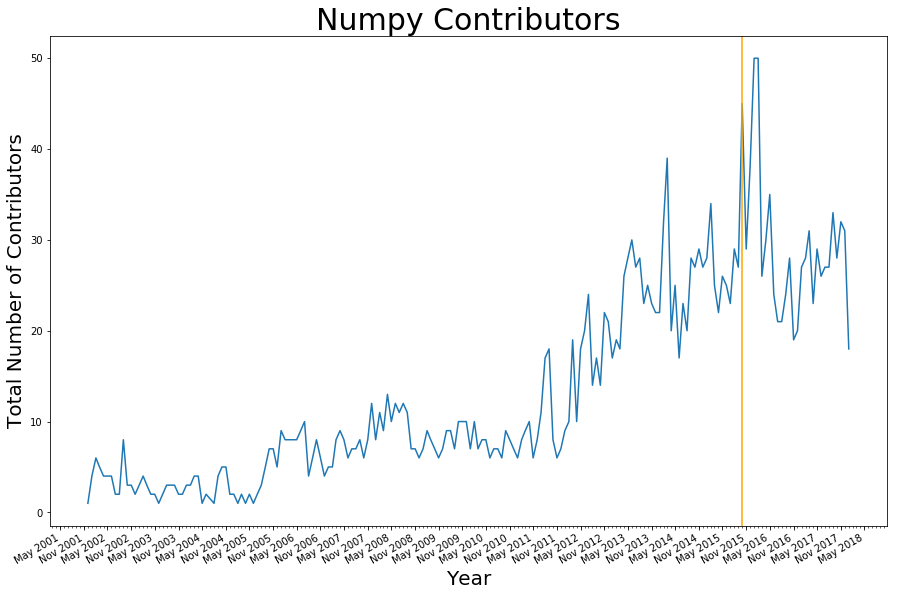

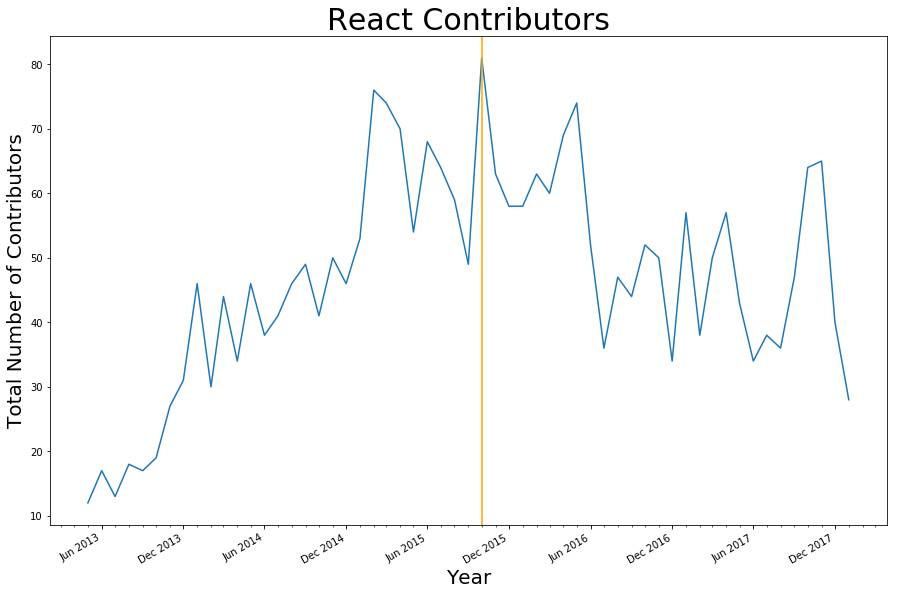

In [53]:
vis_div(b_df, "Bitcoin Contributors")
vis_div(n_df, "Numpy Contributors")
vis_div(r_df, "React Contributors")

### 5. Find the old users

In [19]:
def old_users(df):
    '''
    return the Pandas dataframe of commits done only by the old users
    '''
    div = pick_div(df)
    s = set(df['committer_name_dedup'])
    old_users = []
    for a in s:
        a_df = df[df['committer_name_dedup'] == a]
        a_commit_time_list = list(a_df["committer_time"])
        a_commit_time_list.sort()
        if len(a_commit_time_list) == 0:
            continue
        first = a_commit_time_list[0]
        #first = str(first.year) + '' + str(first.month) if first.month >= 10 else str(first.year) + '0' + str(first.month)
        if first > div:
            continue
        old_users.append(a)
    return df[df['committer_name_dedup'].isin(old_users)]

In [20]:
n_old = old_users(n_df)
r_old = old_users(r_df)
b_old = old_users(b_df)

In [21]:
print("Numpy's number of old users is {}".format(len(set(n_old['committer_name_dedup']))))
print("React's number of old users is {}".format(len(set(r_old['committer_name_dedup']))))
print("Bitcoin's number of old users is {}".format(len(set(b_old['committer_name_dedup']))))

Numpy's number of old users is 452
React's number of old users is 669
Bitcoin's number of old users is 279


### 6. How long do the older users stick around?

In [22]:
def stick_around(df):
    '''
    return 1. the median start date of the old user 
           2. the median last date of the old user
    in 2-tuple form (1, 2)
    '''
    div = pick_div(df)
    s = set(df['committer_name_dedup'])
    n_div = pick_div(df)
    firsts = []
    lasts = []
    for a in s:
        a_df = df[df['committer_name_dedup'] == a]
        a_commit_time_list = list(a_df["committer_time"])
        a_commit_time_list.sort()
        if len(a_commit_time_list) == 0:
            continue
        first = a_commit_time_list[0]
        if first >= n_div:
            continue
        last  = a_commit_time_list[-1]
        first_int = int(time.mktime(first.timetuple()))
        last_int = int(time.mktime(last.timetuple()))
        firsts.append(first_int)
        lasts.append(last_int)
    first_med = statistics.median(firsts)
    last_med = statistics.median(lasts)
    return (datetime.datetime.fromtimestamp(first_med), datetime.datetime.fromtimestamp(last_med))


In [23]:
r_median_time = stick_around(r_df)
n_median_time = stick_around(n_df)
b_median_time = stick_around(b_df)

print("The median time React contributors stuck around is between %s and %s" % r_median_time)
print("The median time Numpy contributors stuck around is between %s and %s" % n_median_time)
print("The median time Bitcoin contributors stuck around is between %s and %s" % b_median_time)

The median time React contributors stuck around is between 2014-12-03 12:28:55 and 2015-03-19 06:45:26
The median time Numpy contributors stuck around is between 2013-11-09 22:02:50.500000 and 2014-06-19 19:53:58
The median time Bitcoin contributors stuck around is between 2012-11-06 05:53:05 and 2013-05-17 15:30:31


In [68]:
def plot_contribution_length(df, name):
    '''
    return 1. the median start date of the old user 
           2. the median last date of the old user
    in 2-tuple form (1, 2)
    '''
    div = pick_div(df)
    s = set(df['committer_name_dedup'])
    n_div = pick_div(df)
    surv_lengths = []
    n_surv_lengths = []
    surv_commits = []
    n_surv_commits = []
    for a in s:
        a_df = df[df['committer_name_dedup'] == a]
        a_commit_time_list = list(a_df["committer_time"])
        a_commit_time_list.sort()
        if len(a_commit_time_list) == 0:
            continue
        first = a_commit_time_list[0]
        last  = a_commit_time_list[-1]
        if first < div:
            if last > div:
                surv_lengths.append(last - first)
                num_commits = len(a_df)
                surv_commits.append(num_commits)
            else:
                n_surv_lengths.append(last - first)
                num_commits = len(a_df)
                n_surv_commits.append(num_commits)
    
    surv_lengths = list(map(lambda l: (l.days + l.seconds / (3600.0 * 24.0)), surv_lengths))
    n_surv_lengths = list(map(lambda l: (l.days + l.seconds / (3600.0 * 24.0)), n_surv_lengths))
    
    survivors = plt.scatter(surv_lengths, surv_commits, label='Survivors')
    nonsurvivors = plt.scatter(n_surv_lengths, n_surv_commits, label='Non-Survivors')
    plt.title("Contributor Data for " + name,fontsize=30)
    plt.ylabel("Number of Commits",fontsize=20)
    plt.xlabel("Number of days between first and last commit", fontsize=20)
    plt.legend(handles=[survivors, nonsurvivors],)
    plt.show()

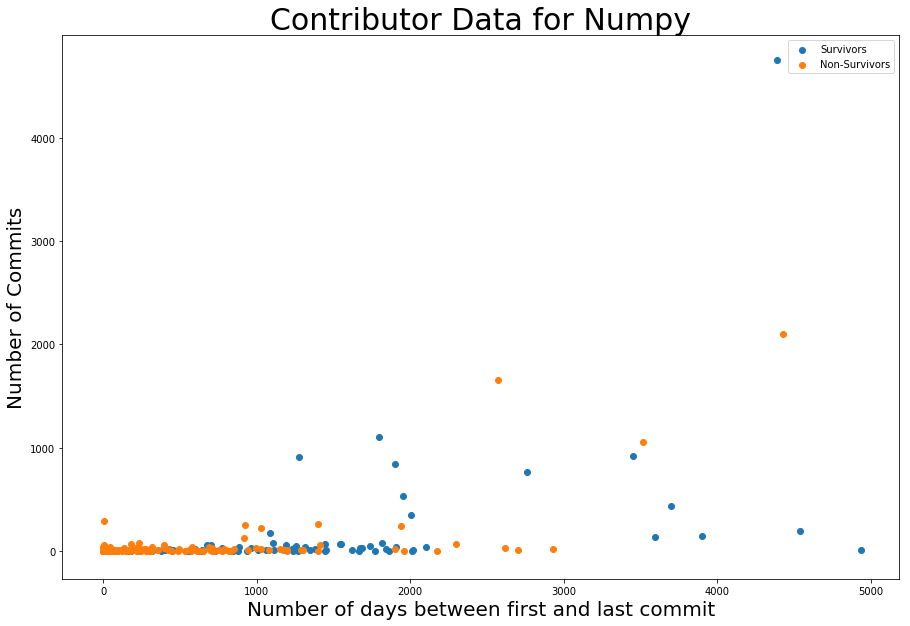

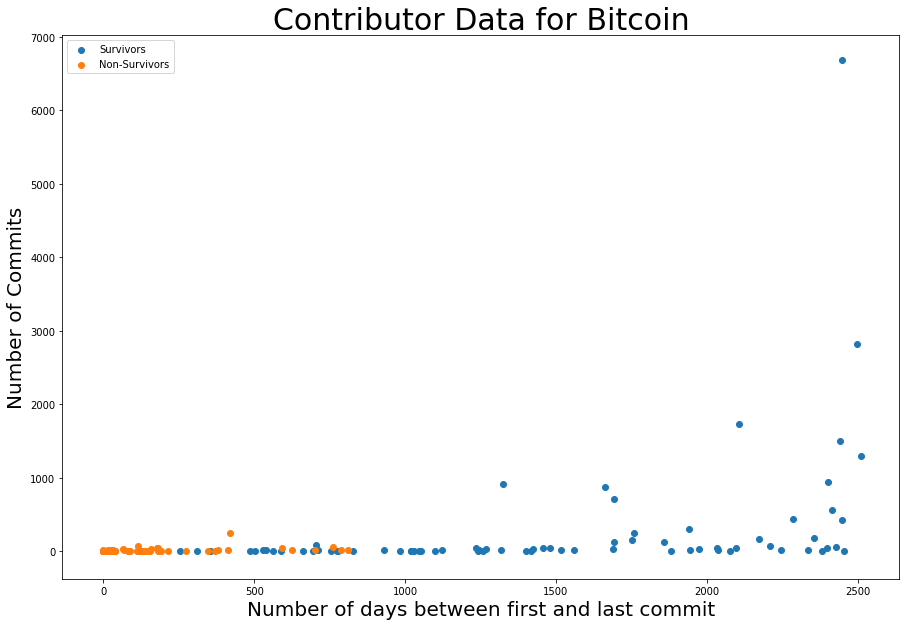

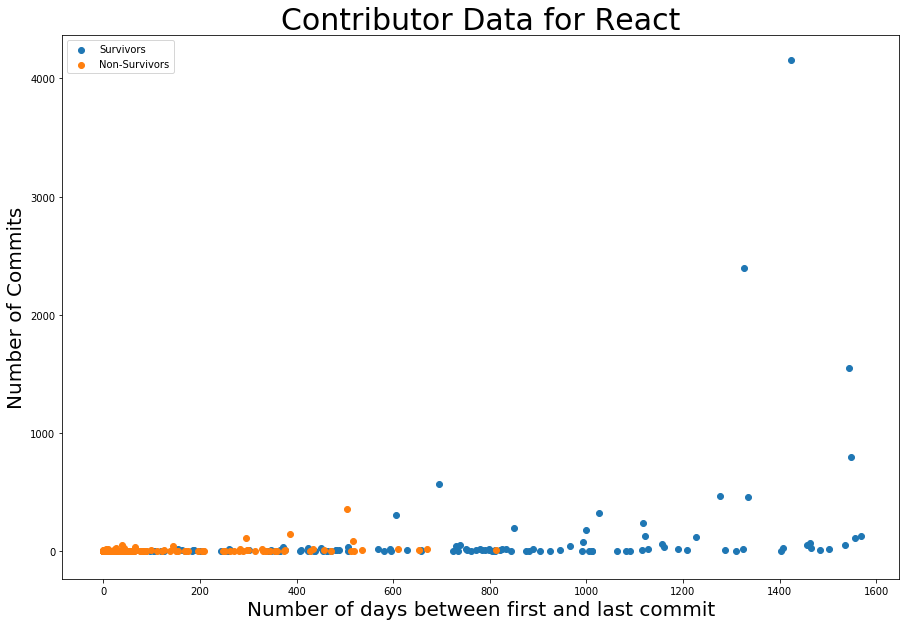

In [69]:
plot_contribution_length(n_df, "Numpy")
plot_contribution_length(b_df, "Bitcoin")
plot_contribution_length(r_df, "React")

In [26]:
def old_before_div(df):
    '''
    Returns the dataframe containing the commits by the old users before the dividing point
    '''
    div = pick_div(df)
    div_year = div.year
    div_month = div.month
    div_day = monthrange(div_year, div_month)[1]
    div = datetime.datetime(div_year, div_month, div_day)
    old_df = old_users(df)
    after_div_df = old_df[old_df['committer_time'] <= div]
    return after_div_df

In [27]:
def old_after_div(df):
    '''
    Returns the dataframe containing the commits by the old users after the dividing point
    '''
    div = pick_div(df)
    div_year = div.year
    div_month = div.month
    div_day = monthrange(div_year, div_month)[1]
    div = datetime.datetime(div_year, div_month, div_day)
    old_df = old_users(df)
    after_div_df = old_df[old_df['committer_time'] > div]
    return after_div_df

In [28]:
n_old_bef = old_before_div(n_df)
r_old_bef = old_before_div(r_df)
b_old_bef = old_before_div(b_df)
n_old_aft = old_after_div(n_df)
r_old_aft = old_after_div(r_df)
b_old_aft = old_after_div(b_df)

In [29]:
# These guys are the entire contributors
n_tot = set(n_df['committer_name_dedup'])
r_tot = set(r_df['committer_name_dedup'])
b_tot = set(b_df['committer_name_dedup'])
# These guys are the old contributors
n_old = set(n_old_bef['committer_name_dedup'])
r_old = set(r_old_bef['committer_name_dedup'])
b_old = set(b_old_bef['committer_name_dedup'])
# These guys are the survivors.
n_surv = set(n_old_aft['committer_name_dedup'])
r_surv = set(r_old_aft['committer_name_dedup'])
b_surv = set(b_old_aft['committer_name_dedup'])
# These guys are the non survivors.
n_nonsurv = n_old - n_surv
r_nonsurv = r_old - r_surv
b_nonsurv = b_old - b_surv
# These guys are the new comers.
n_new = n_tot - n_old
r_new = r_tot - r_old
b_new = b_tot - b_old

print("Number of total contributors")
print("Numpy: {}".format(len(n_tot)))
print("React: {}".format(len(r_tot)))
print("Bitcoin: {}\n".format(len(b_tot)))

print("Number of old contributors")
print("Numpy: {}".format(len(n_old)))
print("React: {}".format(len(r_old)))
print("Bitcoin: {}\n".format(len(b_old)))

print("Number of survivors")
print("Numpy: {}".format(len(n_surv)))
print("React: {}".format(len(r_surv)))
print("Bitcoin: {}\n".format(len(b_surv)))

print("Number of non-survivors")
print("Numpy: {}".format(len(n_nonsurv)))
print("React: {}".format(len(r_nonsurv)))
print("Bitcoin: {}\n".format(len(b_nonsurv)))

print("Number of newcomers")
print("Numpy: {}".format(len(n_new)))
print("React: {}".format(len(r_new)))
print("Bitcoin: {}".format(len(b_new)))

Number of total contributors
Numpy: 751
React: 1358
Bitcoin: 812

Number of old contributors
Numpy: 452
React: 669
Bitcoin: 279

Number of survivors
Numpy: 73
React: 117
Bitcoin: 73

Number of non-survivors
Numpy: 379
React: 552
Bitcoin: 206

Number of newcomers
Numpy: 299
React: 689
Bitcoin: 533


##### Findings
1. Seems like most old contributors leave the project before the project becomes popular! 128 out of 597 from Numpy, 94 out of 826 from React, and 61 out of 352 from Bitcoin survived!

### 7. How did old contributors' behaviour change from before the div point ?
1. We will take only the old users who kept contributing after the div point (call them SURVIVORS from now on) to analyze their behaviour

In [30]:
# These dataframes contain commits by the survivors
n_old_bef_surv = n_old_bef[n_old_bef['committer_name_dedup'].isin(n_surv)]
r_old_bef_surv = r_old_bef[r_old_bef['committer_name_dedup'].isin(r_surv)]
b_old_bef_surv = b_old_bef[b_old_bef['committer_name_dedup'].isin(b_surv)]

# These dataframes contain commits by the non-survivors
n_old_bef_nonsurv = n_old_bef[n_old_bef['committer_name_dedup'].isin(n_nonsurv)]
r_old_bef_nonsurv = r_old_bef[r_old_bef['committer_name_dedup'].isin(r_nonsurv)]
b_old_bef_nonsurv = b_old_bef[b_old_bef['committer_name_dedup'].isin(b_nonsurv)]

# These dataframes contain commits by the newcomers
n_new_df = n_df[n_df['committer_name_dedup'].isin(n_new)]
r_new_df = r_df[r_df['committer_name_dedup'].isin(r_new)]
b_new_df = b_df[b_df['committer_name_dedup'].isin(b_new)]

In [31]:
# Array to be used as the heights of the first bar chart below. 
num_commits_array = []
num_commits_array.append(len(n_old_bef_surv))
num_commits_array.append(len(n_old_aft))
num_commits_array.append(len(r_old_bef_surv))
num_commits_array.append(len(r_old_aft))
num_commits_array.append(len(b_old_bef_surv))
num_commits_array.append(len(b_old_aft))

In [66]:
def vis2(surv_bef, surv_aft, nonsurv, new, df, title):
    months = list(set(surv_bef['month']))
    months.sort()
    # this will contain months as keys and avg # of commits as values
    d = {}
    for m in months:
        m_df = surv_bef[surv_bef['month'] == m]
        num_commit = len(m_df)
        num_author = len(set(m_df['committer_name_dedup']))
        d[m] = num_commit / num_author

    months = list(set(surv_aft['month']))
    months.sort()
    for m in months:
        m_df = surv_aft[surv_aft['month'] == m]
        num_commit = len(m_df)
        num_author = len(set(m_df['committer_name_dedup']))
        d[m] = num_commit / num_author
        
    d2 = {}
    months = list(set(nonsurv['month']))
    months.sort()
    for m in months:
        m_df = nonsurv[nonsurv['month'] == m]
        num_commit = len(m_df)
        num_author = len(set(m_df['committer_name_dedup']))
        d2[m] = num_commit / num_author
    
    div_month = pick_div(df)
    
    d3 = {}
    months = list(set(new['month']))
    months.sort()
    for m in months:
        if m < div_month:
            continue
        m_df = new[new['month'] == m]
        num_commit = len(m_df)
        num_author = len(set(m_df['committer_name_dedup']))
        d3[m] = num_commit / num_author

    

    plt.ylabel('Avg # of commits', fontsize=20)
    plt.xlabel('Time', fontsize=20)
    plt.title(title, fontsize=30)

    plt.gca().xaxis.set_major_locator(MonthLocator(range(1,13), interval=6))
    plt.gca().xaxis.set_major_formatter(DateFormatter('%b %Y'))
    plt.gca().xaxis.set_minor_locator(month_locator)

    all_months = list(d.keys()).sort()
    plt.plot(list(d.keys()),list(d.values()), label='survivors')
    plt.plot(list(d2.keys()), list(d2.values()), label='nonsurvivors')
    plt.plot(list(d3.keys()), list(d3.values()), label='newcomers')
    plt.axvline(x=div_month, color='orange')
    plt.rcParams['figure.figsize'] = [15, 10]
    plt.legend()
    plt.gcf().autofmt_xdate()
    plt.show()

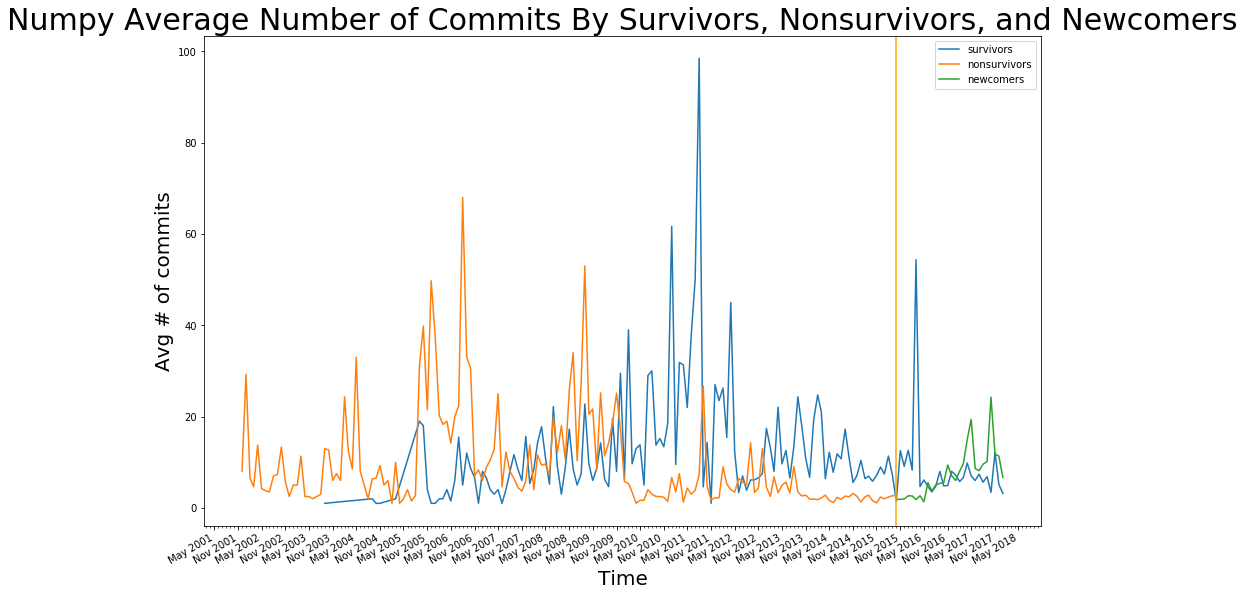

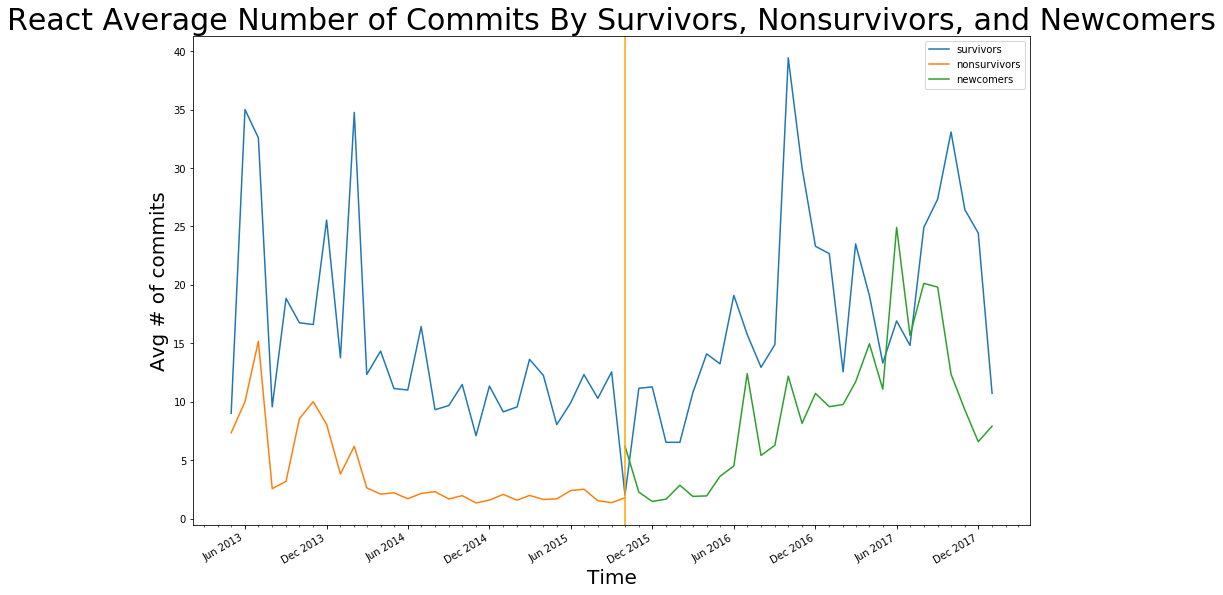

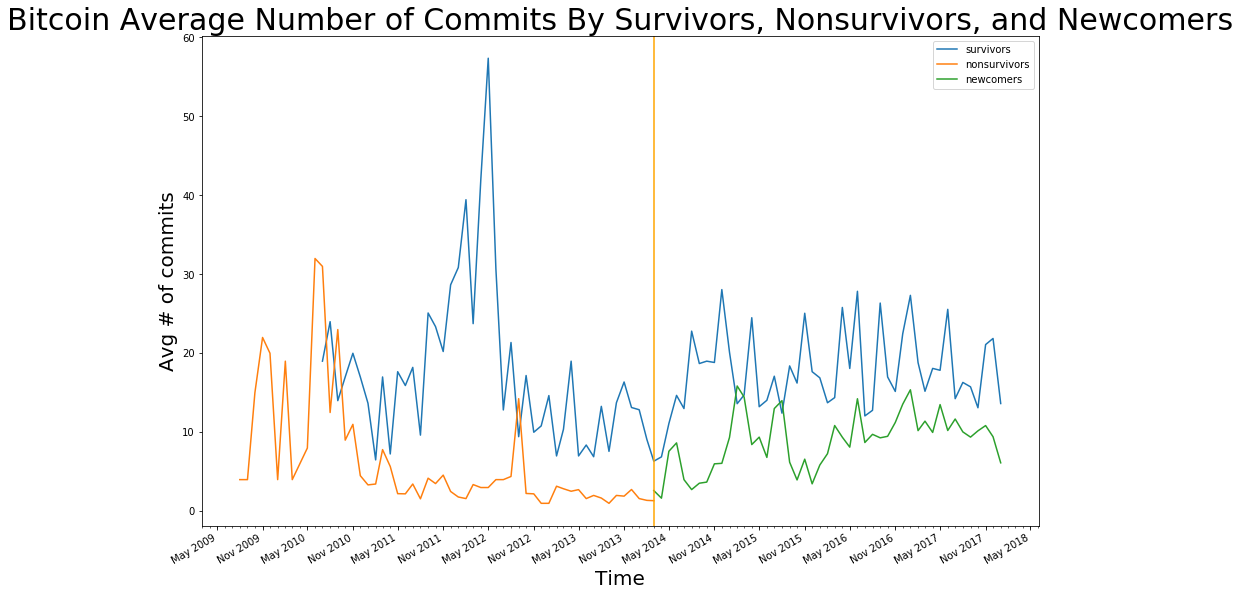

In [67]:
vis2(n_old_bef_surv, n_old_aft, n_old_bef_nonsurv, n_new_df, n_df, "Numpy Average Number of Commits By Survivors, Nonsurvivors, and Newcomers")
vis2(r_old_bef_surv, r_old_aft, r_old_bef_nonsurv, r_new_df, r_df, "React Average Number of Commits By Survivors, Nonsurvivors, and Newcomers")
vis2(b_old_bef_surv, b_old_aft, b_old_bef_nonsurv, b_new_df, b_df, "Bitcoin Average Number of Commits By Survivors, Nonsurvivors, and Newcomers")

<BarContainer object of 6 artists>

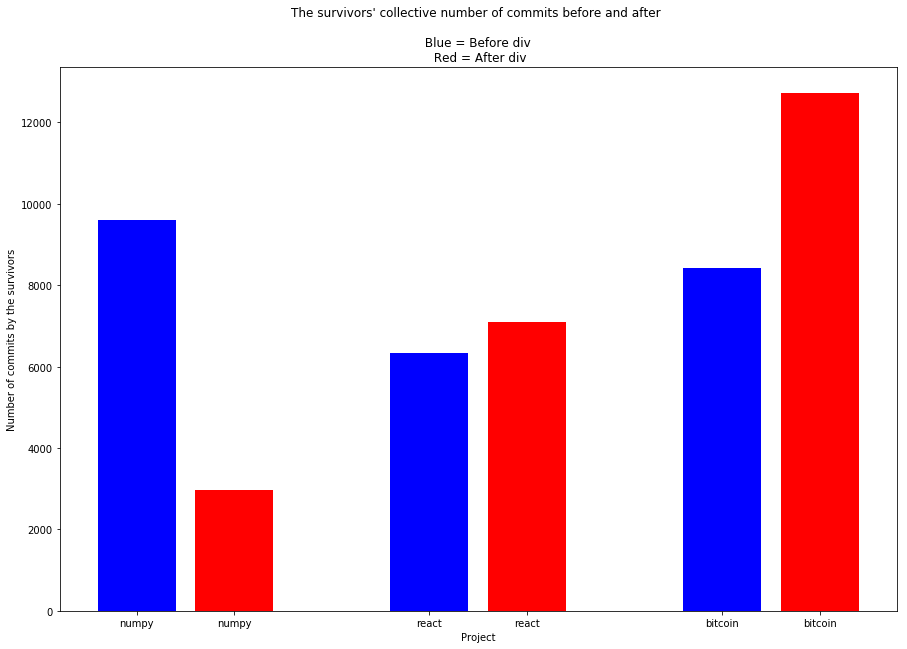

In [34]:
plt.ylabel('Number of commits by the survivors')
plt.xlabel('Project')
plt.title("The survivors' collective number of commits before and after \n\n Blue = Before div \n Red = After div")
plt.bar(x=[1, 2, 4, 5 ,7 ,8], \
        height=num_commits_array, \
        color=['blue','red','blue','red','blue','red'], \
        tick_label=['numpy', 'numpy', 'react', 'react', 'bitcoin', 'bitcoin'])

In [35]:
# Array to be used as the heights of the second bar chart below. 
num_commits_array_2 = []
num_commits_array_2.append((len(n_old_bef) - len(n_old_bef_surv)) / len(n_nonsurv))
num_commits_array_2.append(len(n_old_bef_surv) / len(n_surv))
num_commits_array_2.append((len(r_old_bef) - len(r_old_bef_surv)) / len(r_nonsurv))
num_commits_array_2.append(len(r_old_bef_surv) / len(r_surv))
num_commits_array_2.append((len(b_old_bef) - len(b_old_bef_surv)) / len(b_nonsurv))
num_commits_array_2.append(len(b_old_bef_surv) / len(b_surv))

<BarContainer object of 6 artists>

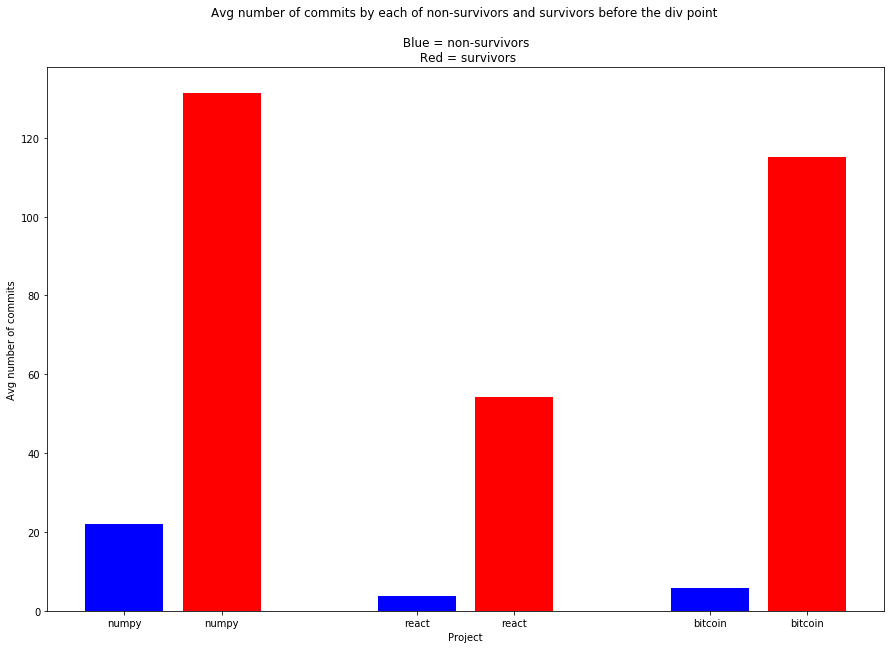

In [36]:
plt.ylabel('Avg number of commits')
plt.xlabel('Project')
plt.title('Avg number of commits by each of non-survivors and survivors before the div point \n\n Blue = non-survivors \n Red = survivors')
plt.bar(x=[1, 2, 4, 5 ,7 ,8], \
        height=num_commits_array_2, \
        color=['blue','red','blue','red','blue','red'], \
        tick_label=['numpy', 'numpy', 'react', 'react', 'bitcoin', 'bitcoin'])

##### Findings
1. (From first bar chart) couldn't find a uniform pattern on the change of survivors' number of commit after the div point. (numpy survivors contributed less, but for the other two projects, the survivors started contributing more)
2. (From second bar chart) we FOUND that the survivors contributed a lot more to the projects compared to the non-survivors. 

##### 7.3 Avg number of files affected by each commit of the survivors before and after the div point

In [37]:
# before 
n_avg_bef_nfiles = sum(list(n_old_bef_surv['nfiles'])) / len(n_old_bef_surv['nfiles'])
r_avg_bef_nfiles = sum(list(r_old_bef_surv['nfiles'])) / len(r_old_bef_surv['nfiles'])
b_avg_bef_nfiles = sum(list(b_old_bef_surv['nfiles'])) / len(b_old_bef_surv['nfiles'])

# after 
n_avg_aft_nfiles = sum(list(n_old_aft['nfiles'])) / len(n_old_aft['nfiles'])
r_avg_aft_nfiles = sum(list(r_old_aft['nfiles'])) / len(r_old_aft['nfiles'])
b_avg_aft_nfiles = sum(list(b_old_aft['nfiles'])) / len(b_old_aft['nfiles'])

<BarContainer object of 6 artists>

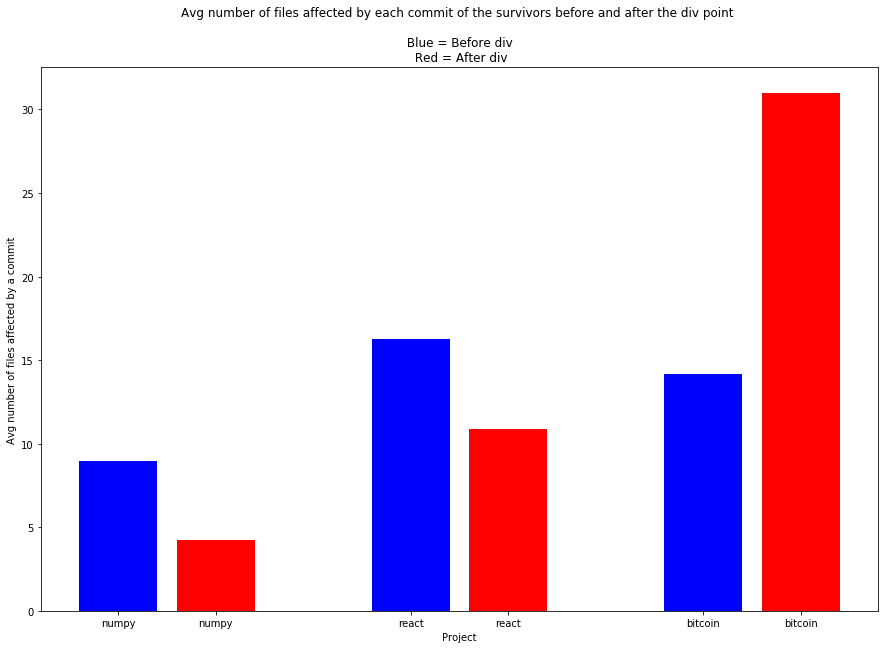

In [38]:
plt.ylabel('Avg number of files affected by a commit')
plt.xlabel('Project')
plt.title("Avg number of files affected by each commit of the survivors before and after the div point \n\n Blue = Before div \n Red = After div")
plt.bar(x=[1, 2, 4, 5 ,7 ,8], \
        height=[n_avg_bef_nfiles, n_avg_aft_nfiles, \
                r_avg_bef_nfiles, r_avg_aft_nfiles, \
                b_avg_bef_nfiles, b_avg_aft_nfiles], \
        color=['blue','red','blue','red','blue','red'], \
        tick_label=['numpy', 'numpy', 'react', 'react', 'bitcoin', 'bitcoin'])

##### 7.4 Entry time for old users! Survivor VS Non-survivors (when did they first start contributing?) 

In [39]:
len(n_df[n_df['committer_name_dedup'].isin(n_surv)])
len(n_df[n_df['committer_name_dedup'].isin(n_nonsurv)])

def entry_points(surv, nonsurv, df):
    '''
    surv : set of survivors
    nonsurv : set of non-survivors
    df : original pandas dataframe 
    '''
    commit_time_list = list(df["committer_time"])
    commit_time_list.sort()
    date1 = commit_time_list[0]
    date2 = pick_div(df)
    delta = datetime.timedelta(weeks=12)
    dates = drange(date1, date2, delta)
        
    s_df = df[df['committer_name_dedup'].isin(surv)]
    ns_df = df[df['committer_name_dedup'].isin(nonsurv)]
    
    s_user_set = set()
    ns_user_set = set()
    
    surv_ent_pt = {}
    nonsurv_ent_pt = {}
    
    for i in range(len(dates)-1):
        # get all the commits between dates[i] and dates[i+1]
        sub_s_df = s_df[(date2num(s_df['committer_time']) > dates[i]) & (date2num(s_df['committer_time']) < dates[i+1])]
        sub_ns_df = ns_df[(date2num(ns_df['committer_time']) > dates[i]) & (date2num(ns_df['committer_time']) < dates[i+1])]
        # create a set of contributors from the commits
        s_sub_user_set = set(sub_s_df['committer_name_dedup'])
        ns_sub_user_set = set(sub_ns_df['committer_name_dedup'])
        # calculate the number of new contributors during that range of time
        surv_ent_pt[dates[i]] = len(s_sub_user_set - s_user_set)
        nonsurv_ent_pt[dates[i]] = len(ns_sub_user_set - ns_user_set)
    
    return surv_ent_pt, nonsurv_ent_pt

In [40]:
def vis3(surv_bef, nonsurv, df, title):
    div_month = pick_div(df)

    months = list(set(nonsurv['month']))
    months.sort()
    d2 = {}
    
    users = set()
    
    for m in months:
        m_df = nonsurv[nonsurv['month'] == m]
        u = set(m_df['committer_name_dedup'])
        d2[m] = len(u - users)
        users = users.union(u)

    d = {}
    
    for m in months:
        m_df = surv_bef[surv_bef['month'] == m]
        u = set(m_df['committer_name_dedup'])
        d[m] = len(u - users)
        users = users.union(u)
    
    print(len(d.keys()))
    print(len(d.values()))
    print(len(d2.keys()))
    print(len(d2.values()))
    
    plt.bar(x=list(d.keys()), height=list(d.values()))
#    plt.bar(x=list(d2.keys()), height=list(d2.values()), bottom=list(d.values()))
        
    plt.ylabel('Number of New Users')
    plt.xlabel('Time')
    plt.title(title)

    plt.gca().xaxis.set_major_locator(MonthLocator(range(1,13), interval=6))
    plt.gca().xaxis.set_major_formatter(DateFormatter('%b %Y'))
    plt.gca().xaxis.set_minor_locator(month_locator)

    plt.axvline(x=div_month, color='orange')
    plt.rcParams['figure.figsize'] = [15, 10]

    plt.gcf().autofmt_xdate()
    plt.show()

165
165
165
165


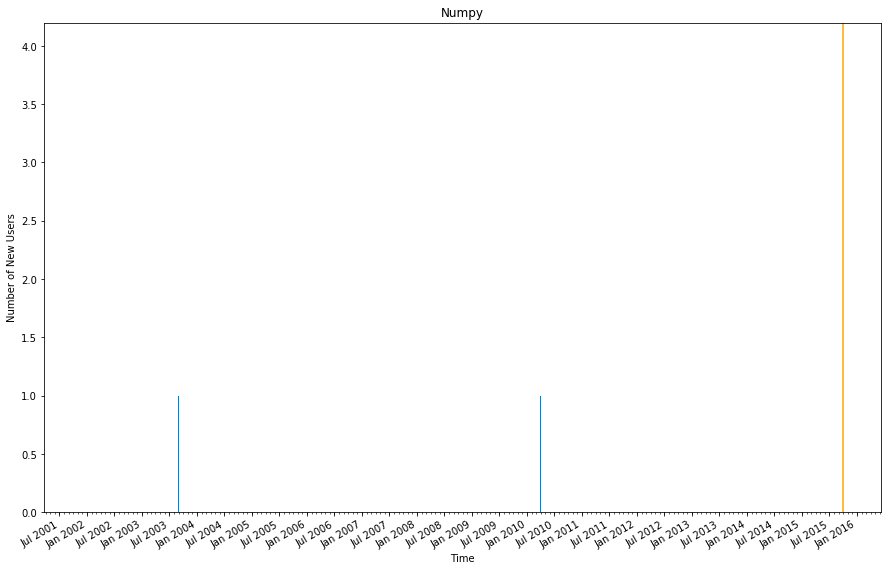

In [41]:
#vis2(n_old_bef_surv, n_old_aft, n_old_bef_nonsurv, n_new_df, n_df, "Numpy")
vis3(n_old_bef_surv, n_old_bef_nonsurv, n_df, "Numpy")

In [42]:
n_surv_ent_pt, n_nonsurv_ent_pt = entry_points(n_surv, n_nonsurv, n_df)
r_surv_ent_pt, r_nonsurv_ent_pt = entry_points(r_surv, r_nonsurv, r_df)
b_surv_ent_pt, b_nonsurv_ent_pt = entry_points(b_surv, b_nonsurv, b_df)

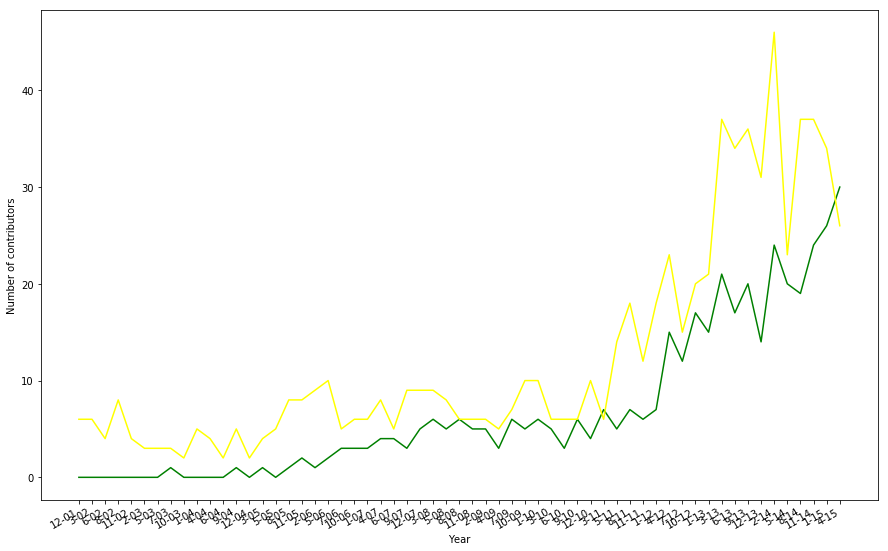

In [43]:
plt.ylabel('Number of contributors')
plt.xlabel('Year')
plt.title('')
dateList = [str(num2date(n).month) + "-" + str(num2date(n).year)[-2:] for n in list(n_nonsurv_ent_pt.keys())]
plt.plot(dateList, list(n_surv_ent_pt.values()), color='green')
plt.plot(dateList, list(n_nonsurv_ent_pt.values()), color='yellow')
#plt.scatter(nonsurv_ent_pt)
plt.rcParams['figure.figsize'] = [25, 20]
plt.gcf().autofmt_xdate()

plt.show()


In [44]:
fig_size = plt.rcParams["figure.figsize"] # Prints: [8.0, 6.0]
print(fig_size)

[25.0, 20.0]


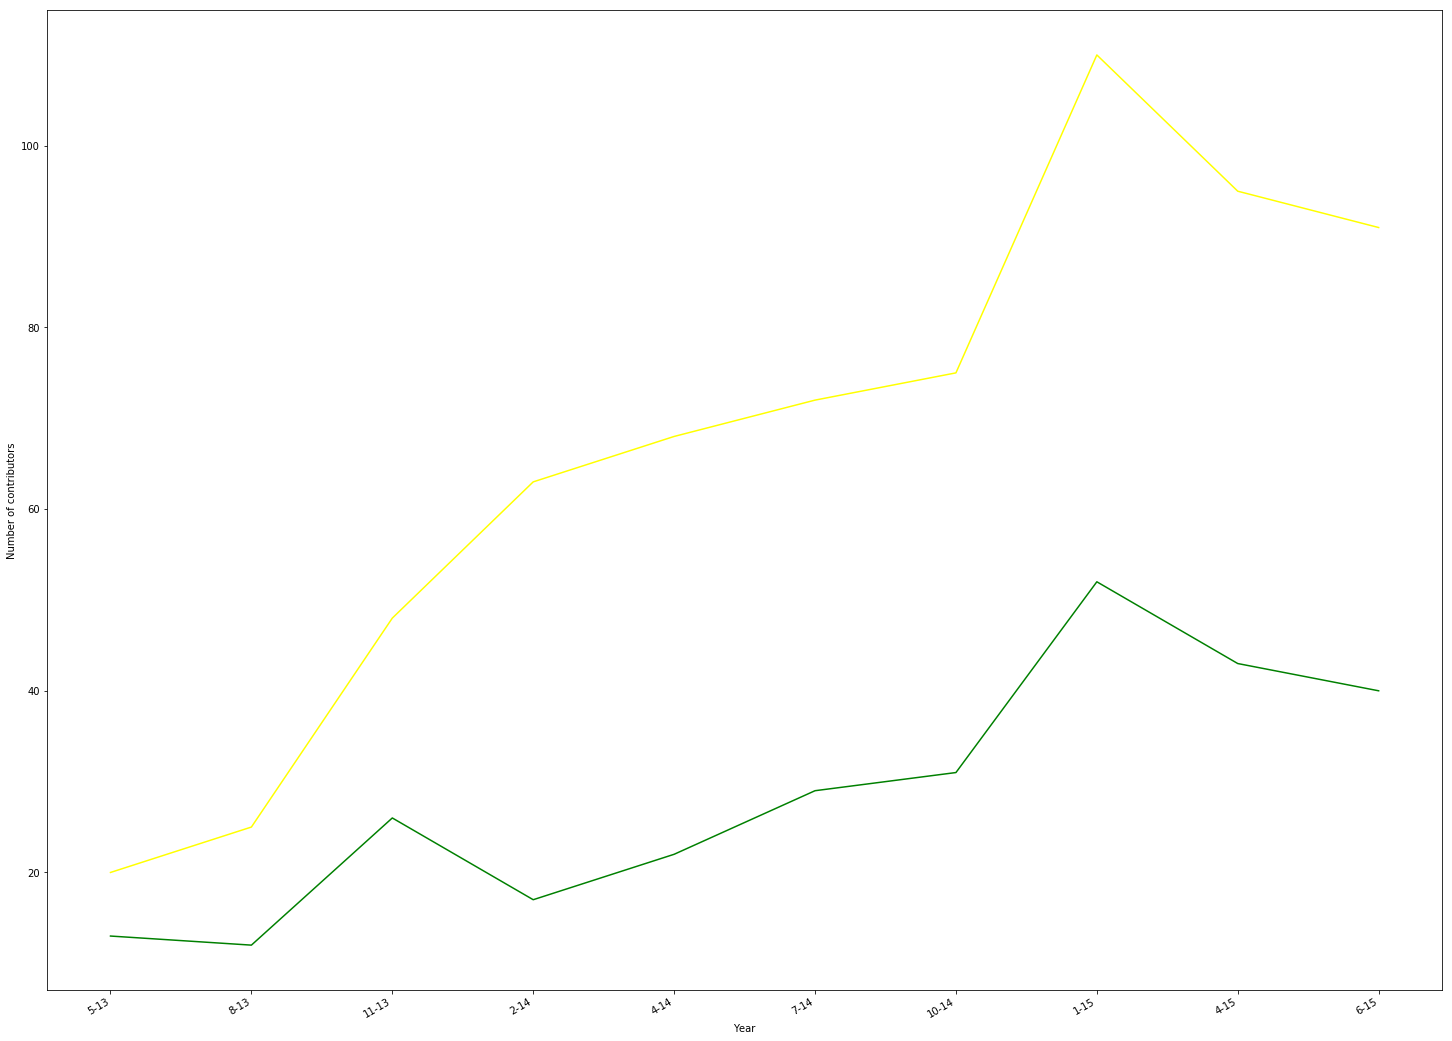

In [45]:
plt.ylabel('Number of contributors')
plt.xlabel('Year')
plt.title('')
dateList = [str(num2date(n).month) + "-" + str(num2date(n).year)[-2:] for n in list(r_surv_ent_pt.keys())]
plt.plot(dateList, list(r_surv_ent_pt.values()), color='green')
plt.plot(dateList, list(r_nonsurv_ent_pt.values()), color='yellow')
plt.gcf().autofmt_xdate()

plt.show()


In [46]:
len(b_nonsurv)

206

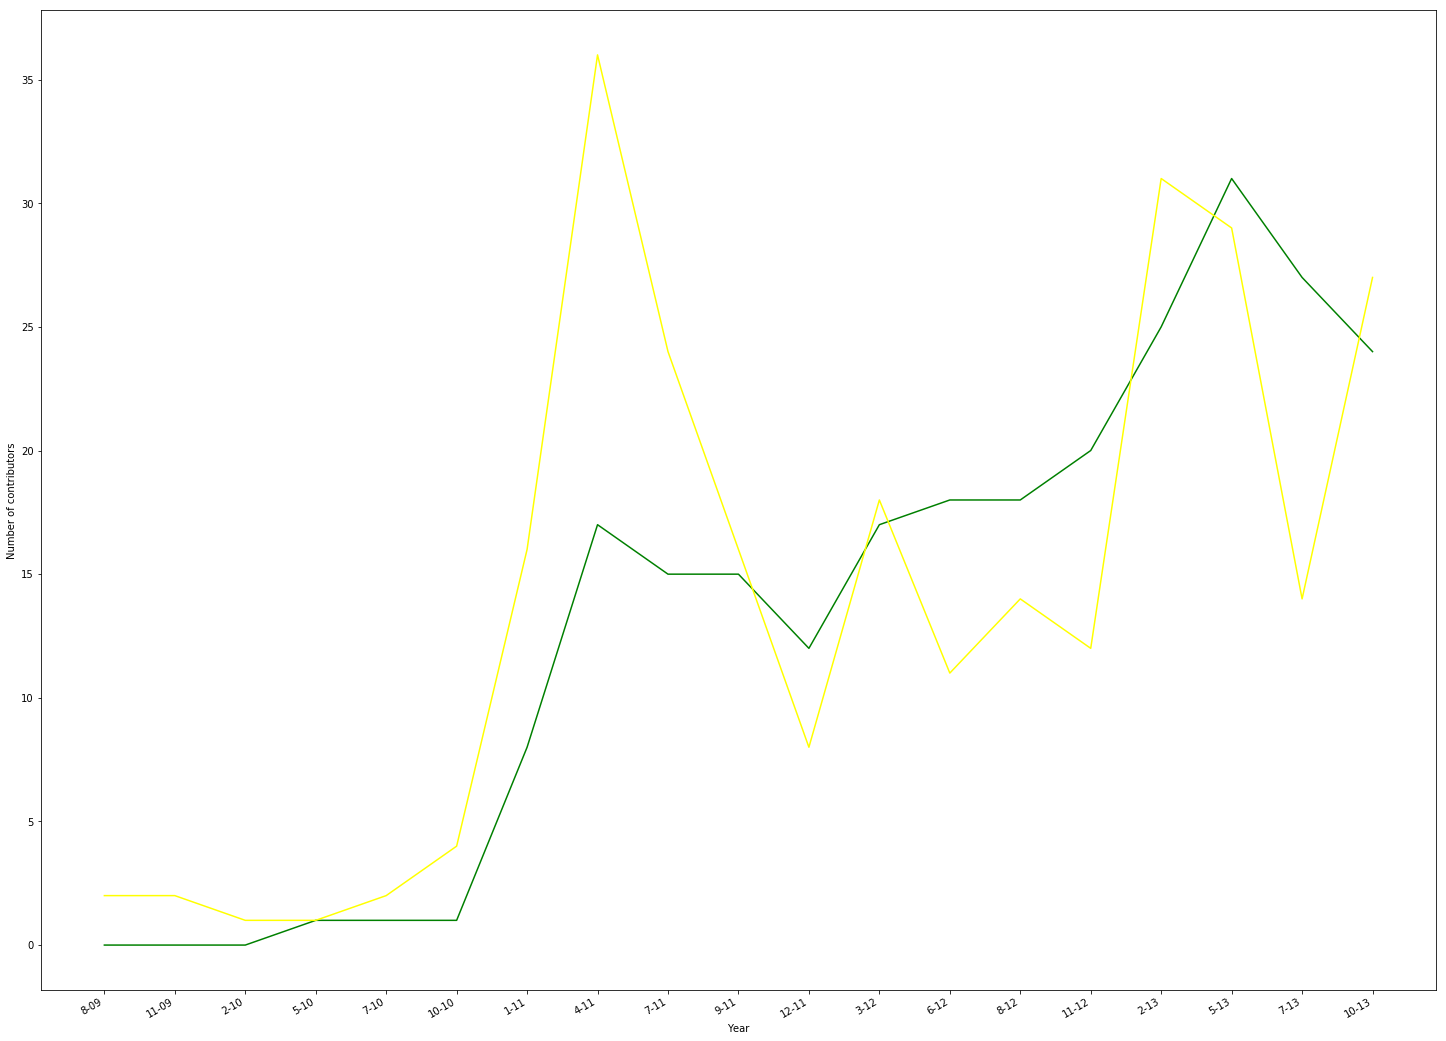

In [47]:
plt.ylabel('Number of contributors')
plt.xlabel('Year')
plt.title('')
dateList = [str(num2date(n).month) + "-" + str(num2date(n).year)[-2:] for n in list(b_surv_ent_pt.keys())]
plt.plot(dateList, list(b_surv_ent_pt.values()), color="green")
plt.plot(dateList, list(b_nonsurv_ent_pt.values()), color='yellow')
plt.gcf().autofmt_xdate()

plt.show()


##### Motivation and Findings
0. originally, we were interested in seeing whether the survivors tend to start contributing to a project earlier than the non-survivors. Thus, being a part of the laying the foundation of the projects.
1. interesting how popular entry time (when they start contributing) for survivors and non-survivors seem to match

In [48]:
x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y)
plt.show()

NameError: name 'lists' is not defined

In [ ]:
import collections

In [ ]:
collections.OrderedDict

In [ ]:
numpy_df[numpy_df['month'] == "2001-12"]

In [ ]:
# read the entire file into a python array
with open('C:/Users/Alberto/nutrients.json', 'rb') as f:
   data = f.readlines()

# remove the trailing "\n" from each line
data = map(lambda x: x.rstrip(), data)

# each element of 'data' is an individual JSON object.
# i want to convert it into an *array* of JSON objects
# which, in and of itself, is one large JSON object
# basically... add square brackets to the beginning
# and end, and have all the individual business JSON objects
# separated by a comma
data_json_str = "[" + ",".join(data) + "]"

# now, load it into pandas
data_df = pd.read_json(data_json_str)